# Подготовка окружения и загрузка данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, mean_absolute_percentage_error

from sklearn.preprocessing import OneHotEncoder
from catboost import CatBoostRegressor, CatBoostClassifier, Pool, cv

try:
    import optuna
except Exception:
    ! pip install optuna
    import optuna
    
try:
    import shap
except Exception:
    ! pip install shap
    import shap
    
pd.set_option("display.max_columns", None)

In [2]:
df = pd.read_csv('df_engineering_new2.csv')

# Baseline - Human learning

В качестве baseline выбрана модель, которая предсказывает среднюю стоимость квадратного метра в группе со схожими значениями общей площади.

В качестве метрики будем использовать MAPE, которая показывает среднее в процентах отклонение предсказанного значения от истинного.

Здесь и далее используется 80% датасета для обучения и 20% для проверки его качества. 

In [4]:
SEED = 26

In [5]:
train, test = train_test_split(df, test_size=.2, random_state=SEED)

y = ['Price_m_2']

square_categories = [0, 30, 40, 50, 60, 70, float('inf')]
square_labels = list(range(len(square_categories) - 1))

train['Total_area_cat'] = pd.cut(train['Total_area'], square_categories, labels=square_labels)
test['Total_area_cat'] = pd.cut(test['Total_area'], square_categories, labels=square_labels)

learning_mask = train.groupby(by='Total_area_cat')[y].agg('median').reset_index()

test = test.merge(learning_mask, how='left', on='Total_area_cat', suffixes=('', '_pred_hl'))

baseline = mean_absolute_percentage_error(test['Price_m_2'], test['Price_m_2_pred_hl'])
baseline

0.23358830480146905

Предложенный baseline ошибается на 23,4%. 
Для определенных задач этого может быть достаточно, но попробуем уменшить значение.

# CatBoost

Моделирование проведем в следующей последовательности:
- кодирование признаков;
- обучение ненастроенной модели CatBoost, проверка качества обучения при помощи кроссвалидации;
- настройка гиперпараметров при помощи Optuna с использованием кроссвалидации;
- анализ важности признаков и исключение наименее важных для моделирования;
- обучение модели на полной обучающей выборке и проверка качества на тестовой.

## Кодирвание признаков

In [6]:
def ohe_transformer(df, cat_features, encoder, encoder_columns):
    ohe = encoder.transform(df[cat_features])
    ohe = pd.DataFrame(ohe, columns=encoder_columns, index=df.index)
    ohe = df.drop(cat_features, axis=1).join(ohe)#.astype('int')
    return ohe

In [7]:
def ohe(train, test, cat_features):
    encoder = OneHotEncoder(drop="first", sparse=False)
    encoder.fit(train[cat_features])
    encoder_columns = ["_".join(x.split()) for x in encoder.get_feature_names_out()]
    return ohe_transformer(
        train, cat_features, encoder, encoder_columns
    ), ohe_transformer(test, cat_features, encoder, encoder_columns), encoder_columns

In [8]:
X = df.drop(y + ['Price', 'Price_m_2'], axis=1).columns.tolist() + ['Total_area_cat']

cat_features = [
    'Repair', 
    'Decoration',
    'Sale_method',
    'House_type', 
    'Participation_type',
    'Total_area_cat'
]

## Обучение ненастроенной модели

In [9]:
pool_train = Pool(
    train[X], 
    train[y],
    cat_features=cat_features
    )

In [10]:
%%time

params = {
    "learning_rate": 0.8,
    "eval_metric": "MAPE",
    "loss_function": "MAPE",
    "random_seed": SEED,
    "early_stopping_rounds": 200,
}

cv_untuned = cv(
    pool=pool_train,
    params=params,
    fold_count=5,
    shuffle=True,
    verbose=250,
    return_models=True,
)

Training on fold [0/5]
0:	learn: 0.2363345	test: 0.2351177	best: 0.2351177 (0)	total: 208ms	remaining: 3m 28s
250:	learn: 0.0986540	test: 0.0999963	best: 0.0999019 (173)	total: 8.47s	remaining: 25.3s
500:	learn: 0.0975495	test: 0.0996263	best: 0.0995780 (470)	total: 20.5s	remaining: 20.5s
750:	learn: 0.0971240	test: 0.0994300	best: 0.0994212 (741)	total: 32.4s	remaining: 10.8s
999:	learn: 0.0967398	test: 0.0994859	best: 0.0993968 (799)	total: 44.4s	remaining: 0us

bestTest = 0.09939681619
bestIteration = 799

Training on fold [1/5]
0:	learn: 0.2354650	test: 0.2351461	best: 0.2351461 (0)	total: 49.5ms	remaining: 49.5s
250:	learn: 0.1053535	test: 0.1129714	best: 0.1129626 (244)	total: 12.1s	remaining: 36.1s
500:	learn: 0.1024552	test: 0.1116340	best: 0.1114847 (459)	total: 24s	remaining: 23.9s
750:	learn: 0.1006407	test: 0.1104030	best: 0.1103337 (645)	total: 36.2s	remaining: 12s
999:	learn: 0.0999579	test: 0.1100113	best: 0.1099658 (924)	total: 48.1s	remaining: 0us

bestTest = 0.1099657

In [11]:
cv_untuned[0]['test-MAPE-mean'].min(), cv_untuned[0]['test-MAPE-std'].min()

(0.09849169517720326, 0.0031390519525412762)

In [12]:
baseline - cv_untuned[0]['test-MAPE-mean'].min()

0.13509660962426578

Получено улучшение относительно baseline менее, чем на 14%.
Это говорит о сильной зашумленности данных, которая может быть частично нивелирована за счет настройки гиперпараметров.

## Настройка гиперпараметров

In [13]:
def objective_cb(trial):

    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.1, 1),
        "eval_metric": "MAPE",
        "loss_function": "MAPE",
        "random_seed": SEED,
        "early_stopping_rounds": 200,
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 10),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "8gb",
    }

    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cv_optuna = cv(
            pool=pool_train,
            params=params,
            fold_count=5,
            shuffle=True,
            verbose=False,
            return_models=True,
            )
    
    return cv_optuna[0]['test-MAPE-mean'].min()

In [14]:
%%time
study_cb = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=SEED))
study_cb.optimize(objective_cb, n_trials=20, show_progress_bar=True)

[I 2023-01-07 15:58:28,322] A new study created in memory with name: no-name-dcebe72a-a376-4d26-a55e-6fb55232d44d
Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/20 [00:00<?, ?it/s]

Training on fold [0/5]

bestTest = 0.1261583468
bestIteration = 776

Training on fold [1/5]

bestTest = 0.1260700764
bestIteration = 974

Training on fold [2/5]

bestTest = 0.1179836219
bestIteration = 983

Training on fold [3/5]

bestTest = 0.1187885705
bestIteration = 966

Training on fold [4/5]

bestTest = 0.1175711311
bestIteration = 988

[I 2023-01-07 16:09:40,617] Trial 0 finished with value: 0.12138695474492722 and parameters: {'learning_rate': 0.37714145736247373, 'min_data_in_leaf': 6, 'colsample_bylevel': 0.07914678953841761, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.12138695474492722.
Training on fold [0/5]

bestTest = 0.1471080483
bestIteration = 984

Training on fold [1/5]

bestTest = 0.142384254
bestIteration = 999

Training on fold [2/5]

bestTest = 0.1520025243
bestIteration = 998

Training on fold [3/5]

bestTest = 0.1373475774
bestIteration = 997

Training on fold [4/5]

bestTest = 0.1447578212
bestIteration = 977


bestTest = 0.1119405802
bestIteration = 119

Training on fold [1/5]

bestTest = 0.1148030545
bestIteration = 177

Training on fold [2/5]

bestTest = 0.1169503779
bestIteration = 185

Training on fold [3/5]

bestTest = 0.1151252886
bestIteration = 120

Training on fold [4/5]

bestTest = 0.1155486239
bestIteration = 587

[I 2023-01-07 16:23:51,924] Trial 12 finished with value: 0.11556569827376459 and parameters: {'learning_rate': 0.9902370008884793, 'min_data_in_leaf': 10, 'colsample_bylevel': 0.0741406841895852, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 11 with value: 0.11509356442106926.
Training on fold [0/5]

bestTest = 0.1555752139
bestIteration = 449

Training on fold [1/5]

bestTest = 0.1596074748
bestIteration = 452

Training on fold [2/5]

bestTest = 0.1535513451
bestIteration = 964

Training on fold [3/5]

bestTest = 0.1511775669
bestIteration = 399

Training on fold [4/5]

bestTest = 0.1645409774
bestIteration = 975

[I 2023-01-07 16:24:

In [15]:
baseline - study_cb.best_trial.value

0.12374088553820581

Получено улучшение относительно baseline на 12,4%. 

## Анализ важности признаков

In [16]:
best_params = study_cb.best_params
#best_params = {'learning_rate': 0.669937374425716, 'min_data_in_leaf': 4, 'colsample_bylevel': 0.09781525853636924, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.401737432094735}

In [17]:
params_tuned = {
        "eval_metric": "MAPE",
        "loss_function": "MAPE",
        "random_seed": SEED,
        "early_stopping_rounds": 200,
        "used_ram_limit": "8gb",
        **best_params
    }

cb_tuned = CatBoostRegressor(**params_tuned, verbose=250)

In [18]:
cb_tuned.fit(pool_train)

0:	learn: 0.2243850	total: 25.5ms	remaining: 25.5s
250:	learn: 0.1025945	total: 3.13s	remaining: 9.34s
500:	learn: 0.0954091	total: 5.91s	remaining: 5.88s
750:	learn: 0.0891531	total: 8.71s	remaining: 2.89s
999:	learn: 0.0850829	total: 11.9s	remaining: 0us


In [19]:
feature_important = pd.DataFrame(
    cb_tuned.feature_importances_, 
    cb_tuned.feature_names_,
    columns=['value']).sort_values(by='value', ascending=False)

feature_important

,value
Price_m_2_cat,20.689181
крестовский остров_dist,6.890660
улица дыбенко_dist,4.023980
Bathroom_convoul,3.697252
Total_area,3.583002
Participation_type,3.397231
купчино_dist,3.354830
Sale_method,3.168871
Total_area_cat,3.080660
Repair,3.059440


In [20]:
def shap_plot(model, train):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(train)
    shap.summary_plot(shap_values, train, plot_size=(15, 8))

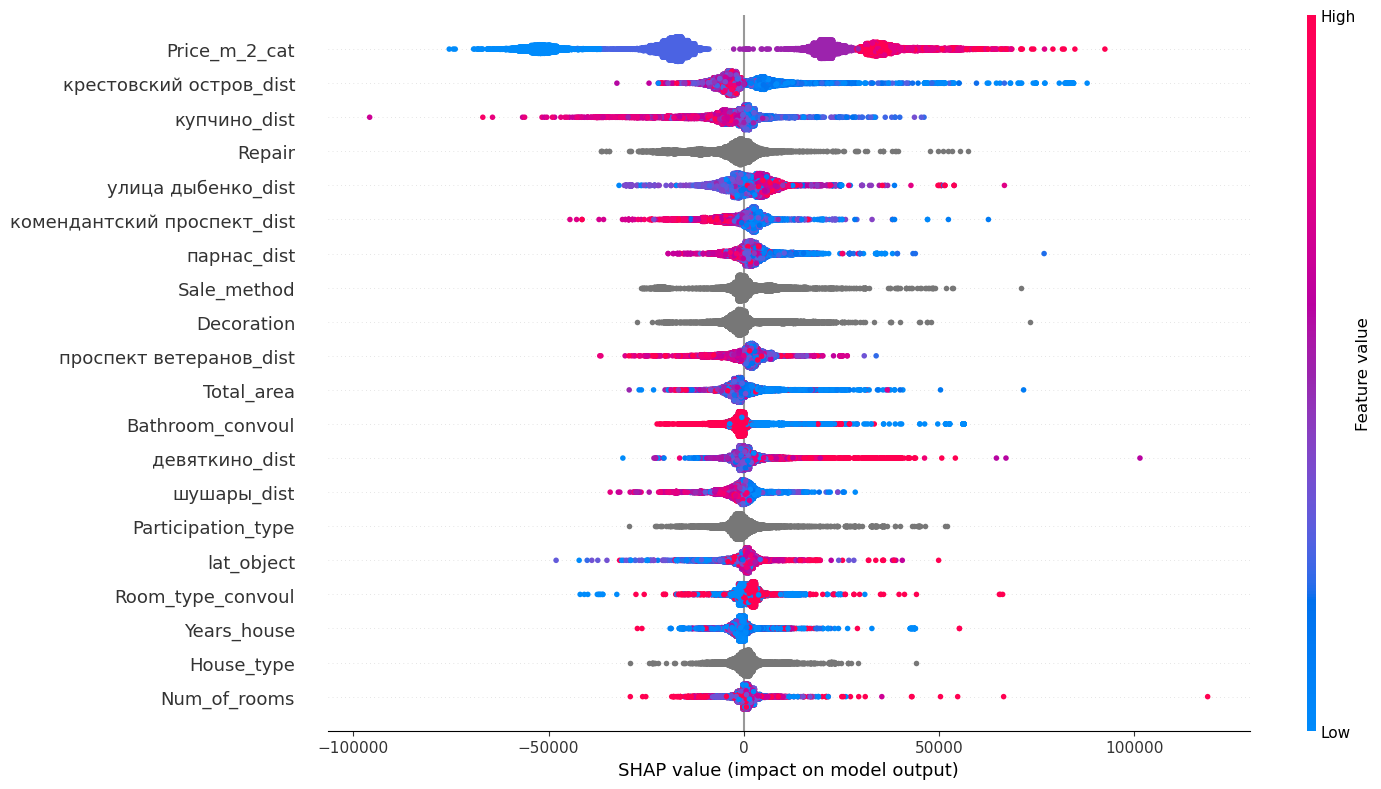

In [21]:
shap_plot(cb_tuned, train[X])

Империческим методом получено, что следующие признаки оказывают наибольшее влияние на качество работы модели.

In [22]:
X_crutial = [
    'Num_of_rooms',
    'Total_area',
    'Floor',
    'lat_object',
    'lon_object',
    'комендантский проспект_dist',
    'крестовский остров_dist',
    'шушары_dist',
    'парнас_dist',
    'купчино_dist',
    'улица дыбенко_dist',
    'девяткино_dist',
    'проспект ветеранов_dist',
    'Price_m_2',
    'Balcony_convoul',
    'Years_house',
    'Cargo_lift_no_info',
    'Passenger_lift_no_info',
    ]

cat_features_crutial = [x for x in cat_features if x in X_crutial]

## Проверка качества модели на тестовой подвыборке

In [23]:
pool_train_crutial = Pool(
    train[X_crutial], 
    train[y],
    cat_features=cat_features_crutial
    )

pool_test = Pool(
    test[X_crutial], 
    test[y],
    cat_features=cat_features_crutial
    )

In [24]:
def objective_cb_fin(trial):

    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.1, 1),
        "eval_metric": "MAPE",
        "loss_function": "MAPE",
        "random_seed": SEED,
        "early_stopping_rounds": 200,
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 10),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "8gb",
    }

    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cv_optuna = cv(
            pool=pool_train_crutial,
            params=params,
            fold_count=5,
            shuffle=True,
            verbose=False,
            return_models=True,
            )
    
    return cv_optuna[0]['test-MAPE-mean'].min()

study_cb_fin = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=SEED))
study_cb_fin.optimize(objective_cb_fin, n_trials=20, show_progress_bar=True)

[I 2023-01-07 16:27:52,675] A new study created in memory with name: no-name-a170611c-896d-4a51-bcc8-a7cd76465e3c
Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/20 [00:00<?, ?it/s]

Training on fold [0/5]

bestTest = 0.119696794
bestIteration = 997

Training on fold [1/5]

bestTest = 0.1309795959
bestIteration = 999

Training on fold [2/5]

bestTest = 0.136151156
bestIteration = 995

Training on fold [3/5]

bestTest = 0.103559789
bestIteration = 999

Training on fold [4/5]

bestTest = 0.154498729
bestIteration = 996

[I 2023-01-07 16:28:28,855] Trial 0 finished with value: 0.12898220223261803 and parameters: {'learning_rate': 0.37714145736247373, 'min_data_in_leaf': 6, 'colsample_bylevel': 0.07914678953841761, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.12898220223261803.
Training on fold [0/5]

bestTest = 0.1897821071
bestIteration = 998

Training on fold [1/5]

bestTest = 0.2073602968
bestIteration = 990

Training on fold [2/5]

bestTest = 0.1735264172
bestIteration = 998

Training on fold [3/5]

bestTest = 0.1829551103
bestIteration = 998

Training on fold [4/5]

bestTest = 0.185230012
bestIteration = 999

[I


bestTest = 0.07477593242
bestIteration = 995

Training on fold [1/5]

bestTest = 0.08885461996
bestIteration = 971

Training on fold [2/5]

bestTest = 0.09603833301
bestIteration = 999

Training on fold [3/5]

bestTest = 0.08860672805
bestIteration = 977

Training on fold [4/5]

bestTest = 0.0848692507
bestIteration = 950

[I 2023-01-07 16:31:40,529] Trial 12 finished with value: 0.08663167977289206 and parameters: {'learning_rate': 0.8500191451157757, 'min_data_in_leaf': 9, 'colsample_bylevel': 0.046220306717048576, 'depth': 12, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.50307609633529}. Best is trial 11 with value: 0.07881296876627039.
Training on fold [0/5]

bestTest = 0.1573922813
bestIteration = 932

Training on fold [1/5]

bestTest = 0.1427930199
bestIteration = 985

Training on fold [2/5]

bestTest = 0.1652307867
bestIteration = 942

Training on fold [3/5]

bestTest = 0.1604461331
bestIteration = 996

Training on fold [4/5]

bestTest = 0.

In [25]:
baseline - study_cb_fin.best_trial.value

0.15477533603519866

In [26]:
best_params_fin = study_cb_fin.best_params

In [27]:
params_fin = {
        "eval_metric": "MAPE",
        "loss_function": "MAPE",
        "random_seed": SEED,
        "early_stopping_rounds": 200,
        "used_ram_limit": "8gb",
        **best_params_fin
    }

cb_fin = CatBoostRegressor(**params_fin, verbose=250)
cb_fin.fit(pool_train_crutial)

0:	learn: 0.2281506	total: 2.4ms	remaining: 2.4s
250:	learn: 0.0792967	total: 1.14s	remaining: 3.4s
500:	learn: 0.0755860	total: 2.02s	remaining: 2.01s
750:	learn: 0.0747661	total: 2.86s	remaining: 950ms
999:	learn: 0.0723832	total: 3.77s	remaining: 0us


In [28]:
test['y_pred_cb'] = cb_fin.predict(pool_test)

mean_absolute_percentage_error(test[y], test['y_pred_cb'])

0.07752369895728033

In [29]:
cb_fin.save_model('catboost_model.json')
cb_fin.save_model('catboost_model.cbm')

# Заключение

Проведено моделирование с использованием инструментов CatBoost, в ходе которого настроены гиперпараметры и используемые признаки.
Получена модель, ошибка предсказания которой не превосходит 7,7%.
Указанное значение почти в 4 раза меньше ошибки предсказания "вручную", используя категоризацию по значению общей площади.